# Explore latent space of trained model


## SETUP

In [1]:
### Environment: conda_gan-tutorial

# Extensions & config
%load_ext autoreload
%autoreload 1

# General package imports
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

# src imports
src_dir = os.path.join(os.getcwd(), "../src")
sys.path.append(src_dir)
%aimport utils, explore, model

In [2]:
# Variables

latent_dim = model.LATENT_DIM_DEF

## TRAINING HISTORY

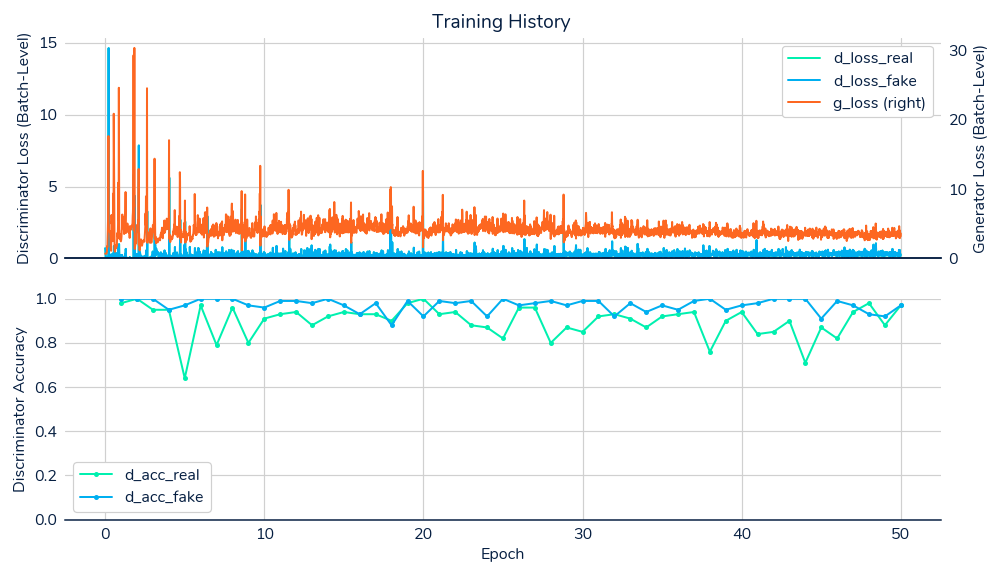

In [4]:
# Plot training history - loss and accuracy

loss_df = pd.read_csv(utils.name_history_file('loss'))
acc_df = pd.read_csv(utils.name_history_file('_acc'))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 8))

loss_df['fract_epoch'] = loss_df.epoch + (loss_df.batch - 1)/loss_df.batch.max()  - 1
loss_df.set_index('fract_epoch').drop(columns=['epoch', 'batch']).plot(ax=axes[0], secondary_y='g_loss')
axes[0].set_ylim(bottom=0)
axes[0].right_ax.set_ylim(bottom=0)
axes[0].set_ylabel("Discriminator Loss (Batch-Level)")
axes[0].right_ax.set_ylabel("Generator Loss (Batch-Level)")
axes[0].grid('x')
axes[0].right_ax.grid(False)

acc_df.set_index('epoch').plot(ax=axes[1], marker='.')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Discriminator Accuracy")
axes[1].set_xlabel("Epoch")

fig.tight_layout()
fig.suptitle("Training History")
plt.show()

Epoch: 30


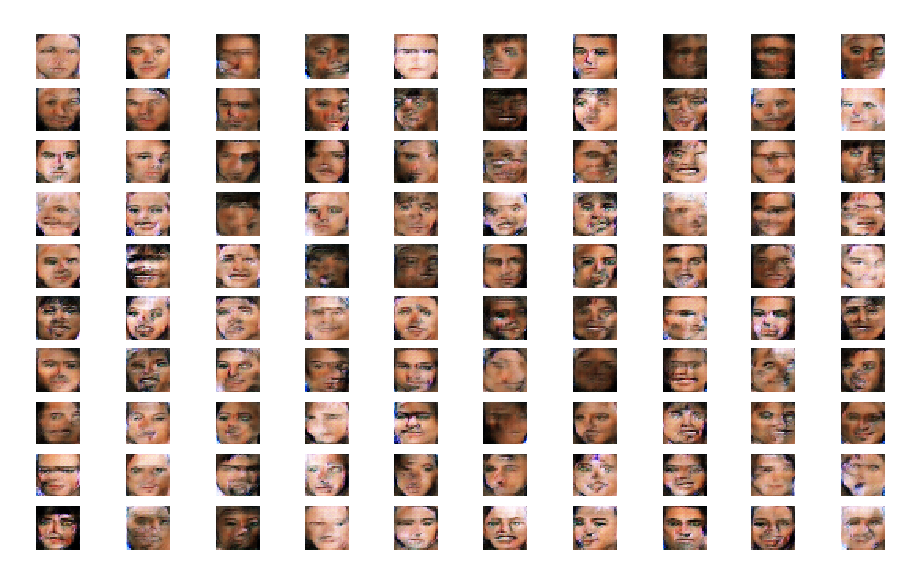

Epoch: 40


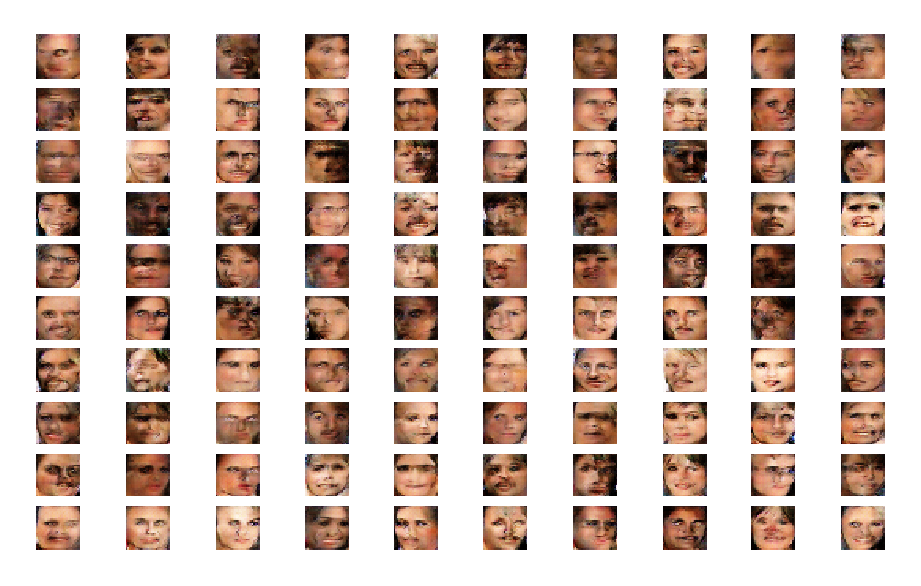

Epoch: 50


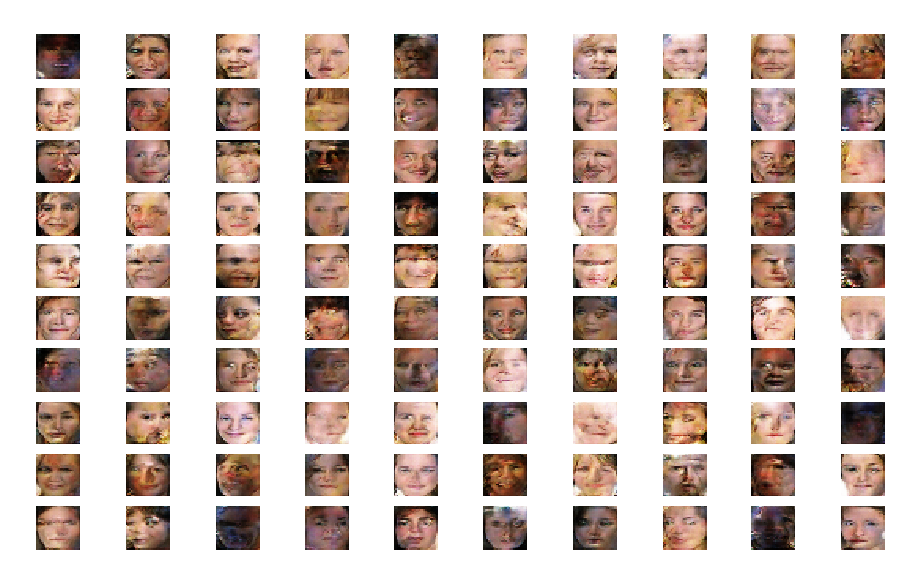

In [8]:
# Look at intermediate images generated through training

for epoch in [30, 40, 50]:
    print(f"Epoch: {epoch}")
    utils.disp_intermed_img(epoch=epoch)

## LOAD MODEL AND GENERATE FACES

In [6]:
# Choose generator model to play with - saved at 10 epoch intervals, and also 'final'

mdl_epoch = 'final'
mdl_fname = utils.name_inter_model_file(mdl_epoch)

g_mdl = load_model(mdl_fname)
print(f"Loaded model: {mdl_fname}")

Loaded model: /home/ubuntu/projects/gan_tutorial/models/generator_model_final.h5


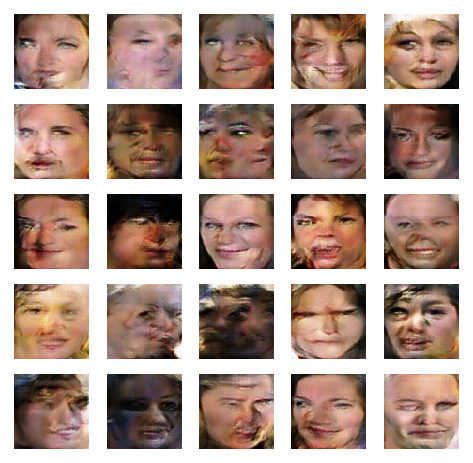

In [7]:
# Generate images from random points in latent space

grid_shape = (5, 5)
n_images = grid_shape[0] * grid_shape[1]

latent_points = model.generate_latent_points(n_images, latent_dim=latent_dim)
images = g_mdl.predict(latent_points)

# Plot generated images
fig = utils.plot_images(images, grid_shape=grid_shape, rescale=True, figsize=(8, 8))
plt.show()

## INTERPOLATE IN LATENT SPACE

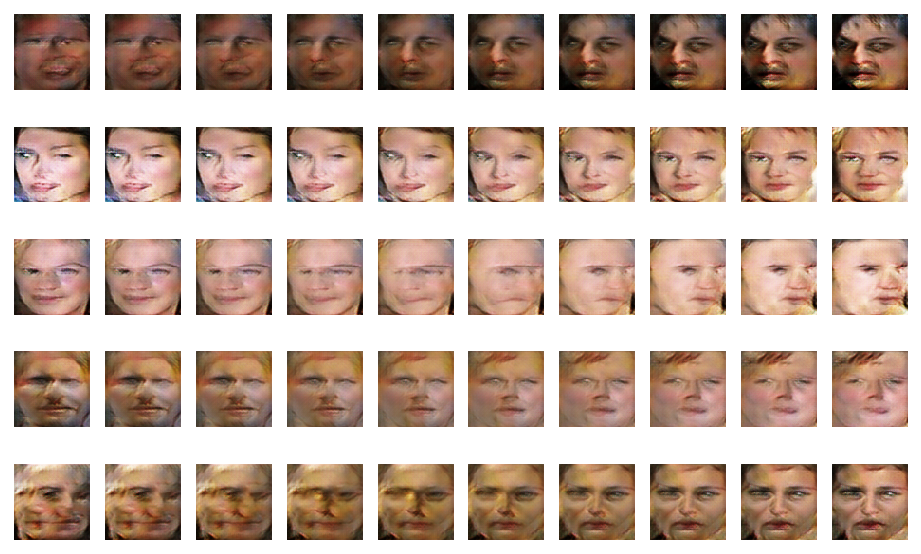

In [8]:
# Construct array of interpolated faces between random points in latent space
# - first pass linear interpolation, not strictly correct in latent space hypersphere

n_steps = 10 # number of interpolation steps between each pair of faces
n_pairs = 5 # number of pairs of faces to interpolate between

latent_pts = model.generate_latent_points(2*n_pairs, latent_dim=latent_dim, seed=42)

images = []
for i in range(0, 2*n_pairs, 2):
    p1, p2 = latent_pts[i], latent_pts[i+1] # endpoints to interpolate between
    interp_pts = explore.interpolate_points(p1, p2, n_steps=n_steps) # n_step interpolations
    interp_img_row = g_mdl.predict(interp_pts) # convert interpolated vectors in latent space to n_step images
    images.append(interp_img_row)
images = np.vstack(images)

fig = utils.plot_images(images, grid_shape=(n_pairs, n_steps), rescale=True)
plt.show()

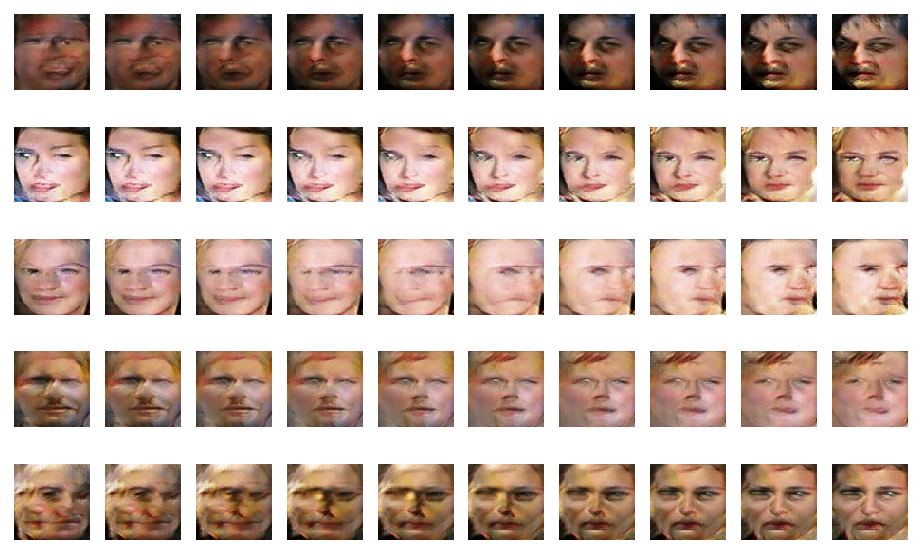

In [9]:
# "More correct" spherical interpolation - see https://github.com/soumith/dcgan.torch/issues/14

n_steps = 10 # number of interpolation steps between each pair of faces
n_pairs = 5 # number of pairs of faces to interpolate between

latent_pts = model.generate_latent_points(2*n_pairs, latent_dim=latent_dim, seed=42)

images = []
for i in range(0, 2*n_pairs, 2):
    p1, p2 = latent_pts[i], latent_pts[i+1] # endpoints to interpolate between
    interp_pts = explore.interpolate_points(p1, p2, n_steps=n_steps, method='spherical') # n_step interpolations
    interp_img_row = g_mdl.predict(interp_pts) # convert interpolated vectors in latent space to n_step images
    images.append(interp_img_row)
images = np.vstack(images)

fig = utils.plot_images(images, grid_shape=(n_pairs, n_steps), rescale=True)
plt.show()

## VECTOR ARITHMETIC IN LATENT SPACE
smiling woman - neutral woman + neutral man = smiling man

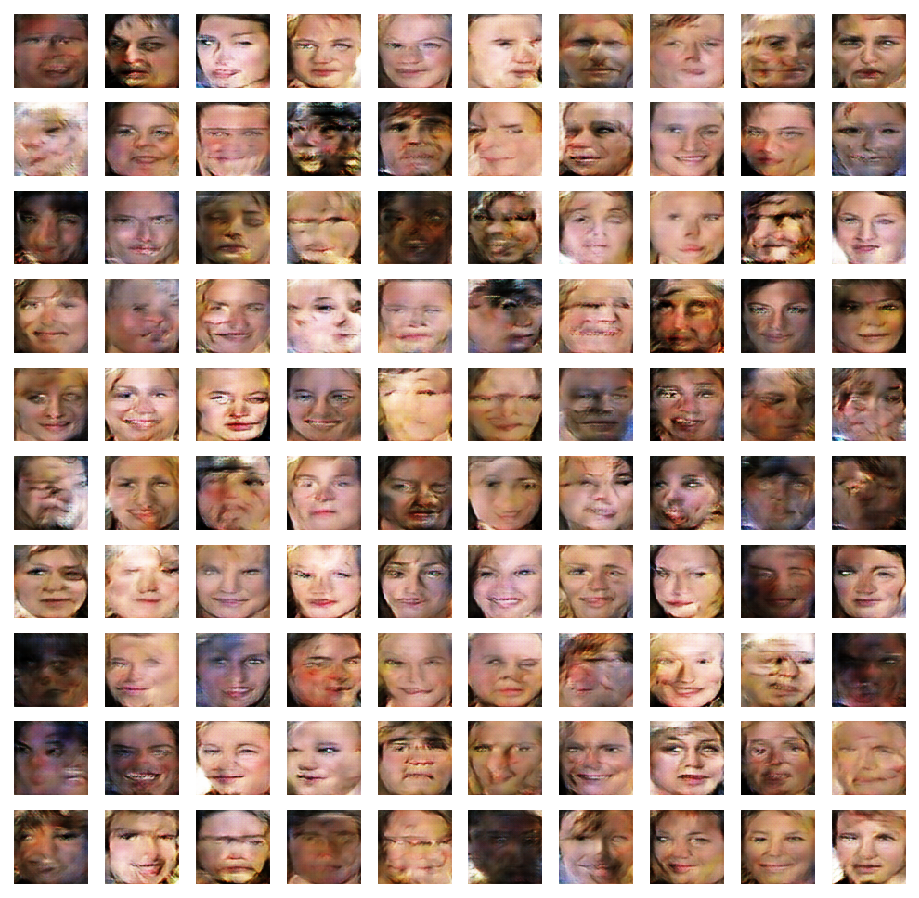

In [10]:
# Need some example faces with features of interest (e.g., smiling woman)

grid_shape = (10, 10)
n_images = grid_shape[0] * grid_shape[1]

latent_points = model.generate_latent_points(n_images, latent_dim=latent_dim, seed=42)
images = g_mdl.predict(latent_points)
fig = utils.plot_images(images, grid_shape=grid_shape, rescale=True)
plt.show()

In [11]:
# Choose representative images for each group (indexed across then down)

groups_idx = {
    'smiling woman': [41, 65, 72],
    'neutral woman': [39, 60, 82],
    'neutral man': [3, 30, 99]
}

In [12]:
# Extract latent space vectors for each set of images (plus average vector), and predict corresponding images

groups_vecs = {}
groups_imgs = {}
for label, indices in groups_idx.items():
    vectors = explore.append_avg_vector(latent_points[indices])
    groups_vecs[label] = vectors
    images = g_mdl.predict(vectors)
    groups_vecs[label] = vectors
    groups_imgs[label] = images


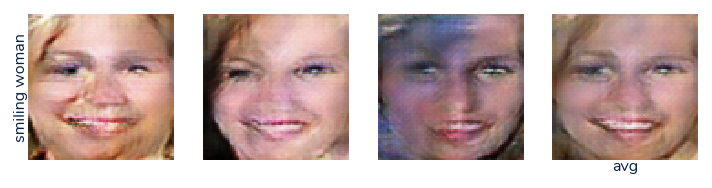

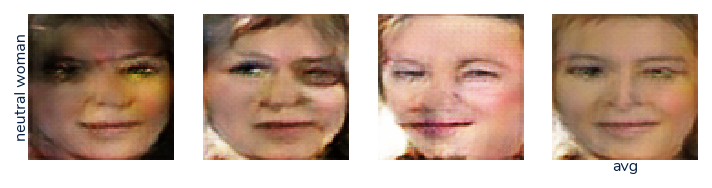

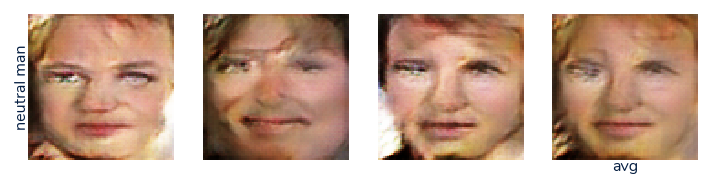

In [13]:
# Plot the representative sets

for label, images in groups_imgs.items():
    fig = explore.plot_representative_img_set(images, label)
    plt.show()

In [14]:
# Vector arithmetic for 'smiling man', using average vector from each set

smiling_man_vec = groups_vecs['smiling woman'][-1] - groups_vecs['neutral woman'][-1] + groups_vecs['neutral man'][-1]
smiling_man_vec = np.expand_dims(smiling_man_vec, axis=0)

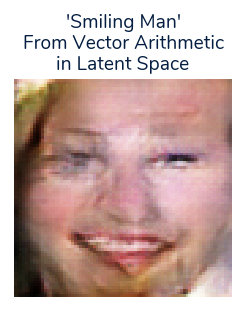

In [15]:
# Construct image for smiling man vector, and plot

smiling_man_img = g_mdl.predict(smiling_man_vec)
fig = utils.plot_images(smiling_man_img, 1, rescale=True, figsize=(4,4))
plt.title("'Smiling Man'\nFrom Vector Arithmetic\nin Latent Space")
plt.show()

## OLD / BACKUP CELLS

In [16]:
raise RuntimeError('Stop here, dont run old cells')

RuntimeError: Stop here, dont run old cells